In [1]:
# pip install transformers

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, TensorDataset
import sys
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoModel, AutoTokenizer
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoTokenizer
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
from collections import defaultdict
from captum.attr import IntegratedGradients
import random
from itertools import product 

In [3]:
# Load Custom Functions
sys.path.append('./model')
from custom_functions import load_raw_data, extract_icd_codes, extract_dynamic_data_dict, extract_demographic_features, summarize_dynamic_features

In [4]:
# Set Seed for all packages
def set_seed(seed=42):
    """Set seeds to make the experiment more reproducible."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load Data

In [5]:
# Define the percentage to load
percentage = '25%'  # Change this to '5%', '10%', etc., as needed

# Base directory for the data subsets
base_dir = f'./data/subsets/{percentage}_subsets/'

# Load Labels
labels = pd.read_csv(f'{base_dir}labels.csv')
stay_ids = labels['stay_id'].unique()

# Load static features
icd_features = pd.read_pickle(f'{base_dir}icd_code_features.pkl')

# Load summarized dynamic features
sum_dynamic_features = pd.read_pickle(f'{base_dir}sum_dynamic_features.pkl')

# Load demographic features
demographic_features = pd.read_pickle(f'{base_dir}demographic_features.pkl')

# Print information to confirm the files are loaded
print(f"Files for {percentage} subset loaded successfully.")
print(f"Number of stays: {len(stay_ids)}")
print(f"ICD Features shape: {icd_features.shape}")
print(f"Summarized Dynamic Features shape: {sum_dynamic_features.shape}")
print(f"Demographic Features shape: {demographic_features.shape}")

Files for 25% subset loaded successfully.
Number of stays: 11895
ICD Features shape: (11895, 1458)
Summarized Dynamic Features shape: (11895, 16)
Demographic Features shape: (11895, 4)


In [6]:
# Merge the DataFrames along the columns (axis=1)
all_static_features = pd.concat([icd_features, demographic_features], axis=1)

# Train Test Split

In [7]:
# Split data into training and temp sets (temp will be split into validation and test)
train_stays, temp_stays = train_test_split(labels, test_size=0.3, random_state=42, stratify=labels['label'])

# Now split temp into test and validation sets equally
test_stays, val_stays = train_test_split(temp_stays, test_size=0.5, random_state=42, stratify=temp_stays['label'])

# Scaling & Encoding of Static Features

In [8]:
# Create Slices of icd_code features for each set
icd_features_train = icd_features.loc[train_stays['stay_id']]
icd_features_val = icd_features.loc[val_stays['stay_id']]
icd_features_test = icd_features.loc[test_stays['stay_id']]

In [9]:
# Create Slices of all_static features for each set
static_features_train = all_static_features.loc[train_stays['stay_id']]
static_features_val = all_static_features.loc[val_stays['stay_id']]
static_features_test = all_static_features.loc[test_stays['stay_id']]

Continous Features

In [10]:
# Selecting Continious Columns for the Different Sets
continous_static_columns_train = static_features_train[["Age"]]
continous_static_columns_val = static_features_val[["Age"]]
continous_static_columns_test = static_features_test[["Age"]]

In [11]:
# Train Standard Scaler on the Train Set and apply it to Train, Validation and Test Set 
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(continous_static_columns_train)

# Scale Training Set in a way that yields a Data Frame again
continous_static_columns_train = pd.DataFrame(
    scaler.transform(continous_static_columns_train),
    index=continous_static_columns_train.index,
    columns=continous_static_columns_train.columns
)

# Scale Training Set in a way that yields a Data Frame again
continous_static_columns_val = pd.DataFrame(
    scaler.transform(continous_static_columns_val),
    index=continous_static_columns_val.index,
    columns=continous_static_columns_val.columns
)

# Scale Training Set in a way that yields a Data Frame again
continous_static_columns_test = pd.DataFrame(
    scaler.transform(continous_static_columns_test),
    index=continous_static_columns_test.index,
    columns=continous_static_columns_test.columns
)

Categorical Features

In [12]:
# Selecting Categorical Columns for the Different Sets
categorical_columns = ['gender', 'ethnicity', 'insurance']  
categorical_static_columns_train = static_features_train[categorical_columns]
categorical_static_columns_val = static_features_val[categorical_columns]
categorical_static_columns_test = static_features_test[categorical_columns]

In [13]:
# Initialize the encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit the encoder on the training data
encoder.fit(categorical_static_columns_train)

# Apply the encoder to the train, validation, and test data
categorical_static_columns_train_encoded = pd.DataFrame(
    encoder.transform(categorical_static_columns_train),
    index=categorical_static_columns_train.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

categorical_static_columns_val_encoded = pd.DataFrame(
    encoder.transform(categorical_static_columns_val),
    index=categorical_static_columns_val.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

categorical_static_columns_test_encoded = pd.DataFrame(
    encoder.transform(categorical_static_columns_test),
    index=categorical_static_columns_test.index,
    columns=encoder.get_feature_names_out(categorical_columns)
)

C:\Users\soere\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Boolean Features (ICD Codes)

In [14]:
# Select Boolean columns for each set (ICD Codes)
bool_static_columns_train = static_features_train[icd_features.columns]
bool_static_columns_val = static_features_val[icd_features.columns]
bool_static_columns_test = static_features_test[icd_features.columns]

In [15]:
# Convert Boolean Columns to Float for Consistent Formatting
bool_static_columns_train = bool_static_columns_train.astype(float)
bool_static_columns_val = bool_static_columns_val.astype(float)
bool_static_columns_test = bool_static_columns_test.astype(float)

Combine Data Frames Back into one per Set

In [16]:
# Combine all parts into one DataFrame using pd.concat
processed_static_features_train = pd.concat([continous_static_columns_train, categorical_static_columns_train_encoded, bool_static_columns_train], axis=1)
processed_static_features_test = pd.concat([continous_static_columns_test, categorical_static_columns_test_encoded, bool_static_columns_test], axis=1)
processed_static_features_val = pd.concat([continous_static_columns_val, categorical_static_columns_val_encoded, bool_static_columns_val], axis=1)

# Tokenization and Embedding of ICD Codes Using Med-BERT

Create ICD Sequences

In [17]:
# Function to create a sequence of ICD codes for each stay_id
def create_icd_sequence(row):
    # Filter the ICD codes that are present (value == 1.0)
    present_codes = [code for code in row.index if row[code] == 1.0]
    return ' '.join(present_codes)  # Joining codes into a single string

# Apply the function to each row and create a new DataFrame
train_icd_sequences = bool_static_columns_train.apply(create_icd_sequence, axis=1).reset_index()
train_icd_sequences.columns = ['stay_id', 'icd_sequence']

# Apply the function to each row and create a new DataFrame
val_icd_sequences = bool_static_columns_val.apply(create_icd_sequence, axis=1).reset_index()
val_icd_sequences.columns = ['stay_id', 'icd_sequence']

# Apply the function to each row and create a new DataFrame
test_icd_sequences = bool_static_columns_test.apply(create_icd_sequence, axis=1).reset_index()
test_icd_sequences.columns = ['stay_id', 'icd_sequence']

Oversample Minority Class

In [18]:
# Add label to train_icd_sequences for Oversampling
train_icd_sequences = pd.merge(labels, train_icd_sequences, on='stay_id', how='inner')

# Applying oversampling
ros = RandomOverSampler(random_state=42)
train_icd_sequences, y_resampled = ros.fit_resample(train_icd_sequences, train_icd_sequences['label'])

print(train_icd_sequences["label"].mean())

0.5


# Tokenization

In [19]:
# Calculate the length of each ICD sequence
train_icd_sequences['length'] = train_icd_sequences['icd_sequence'].apply(lambda x: len(x.split()))
# Calculate the length of each ICD sequence
val_icd_sequences['length'] = val_icd_sequences['icd_sequence'].apply(lambda x: len(x.split()))
# Calculate the length of each ICD sequence
test_icd_sequences['length'] = test_icd_sequences['icd_sequence'].apply(lambda x: len(x.split()))

# Calculate percentiles
train_percentiles = np.percentile(train_icd_sequences['length'], [0, 25, 50, 75, 100])  # Modify if you need other percentiles
val_percentiles = np.percentile(val_icd_sequences['length'], [0, 25, 50, 75, 100])  # Modify if you need other percentiles
test_percentiles = np.percentile(test_icd_sequences['length'], [0, 25, 50, 75, 100])  # Modify if you need other percentiles

print("Percentiles of Training sequence lengths: 0th, 25th, 50th, 75th, 100th:", train_percentiles)
print("Percentiles of Validation sequence lengths: 0th, 25th, 50th, 75th, 100th:", val_percentiles)
print("Percentiles of Testing sequence lengths: 0th, 25th, 50th, 75th, 100th:", test_percentiles)

Percentiles of Training sequence lengths: 0th, 25th, 50th, 75th, 100th: [ 0. 12. 17. 23. 38.]
Percentiles of Validation sequence lengths: 0th, 25th, 50th, 75th, 100th: [ 1. 11. 16. 21. 38.]
Percentiles of Testing sequence lengths: 0th, 25th, 50th, 75th, 100th: [ 0. 11. 16. 21. 39.]


In [20]:
# Load the tokenizer for MedBERT
tokenizer = AutoTokenizer.from_pretrained('Charangan/MedBERT')

# Specify a max_length for tokenization to ensure truncation
max_length = 38  # This is the maximum length of sequences in the dataset

# Tokenize the sequences with explicit padding and truncation
tokenized_train_data = tokenizer(train_icd_sequences['icd_sequence'].tolist(),
                           padding="max_length",  # ensures all sequences are padded to the same length
                           truncation=True,       # enables truncation to max_length
                           max_length=max_length, # explicitly set max_length
                           return_tensors="pt")   # returns PyTorch tensors

tokenized_val_data = tokenizer(val_icd_sequences['icd_sequence'].tolist(),
                           padding="max_length",  # ensures all sequences are padded to the same length
                           truncation=True,       # enables truncation to max_length
                           max_length=max_length, # explicitly set max_length
                           return_tensors="pt")   # returns PyTorch tensors

tokenized_test_data = tokenizer(test_icd_sequences['icd_sequence'].tolist(),
                           padding="max_length",  # ensures all sequences are padded to the same length
                           truncation=True,       # enables truncation to max_length
                           max_length=max_length, # explicitly set max_length
                           return_tensors="pt")   # returns PyTorch tensors


# Embedding

In [21]:
# Load MedBERT model
MedBERTmodel = AutoModel.from_pretrained('Charangan/MedBERT')

# Ensure the model is in evaluation mode
MedBERTmodel.eval()

# Define input ids and attention masks
input_train_ids = tokenized_train_data['input_ids']
train_attention_mask = tokenized_train_data['attention_mask']

input_val_ids = tokenized_val_data['input_ids']
val_attention_mask = tokenized_val_data['attention_mask']

input_test_ids = tokenized_test_data['input_ids']
test_attention_mask = tokenized_test_data['attention_mask']

# Define the batch size
batch_size = 100  # Adjust this based on your available memory

# Calculate the number of batches
num_batches = (input_train_ids.size(0) + batch_size - 1) // batch_size

# List to store all embeddings
all_embeddings = []

In [22]:
## Embedding Generation for Training Set
# Process each batch
for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = min(batch_start + batch_size, input_train_ids.size(0))
    
    # Slice the batch data
    batch_input_ids = input_train_ids[batch_start:batch_end]
    batch_attention_mask = train_attention_mask[batch_start:batch_end]

    # Forward pass to get embeddings
    with torch.no_grad():
        batch_outputs = MedBERTmodel(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = batch_outputs.last_hidden_state  # Extract embeddings
    
    # Store the embeddings
    all_embeddings.append(batch_embeddings)
    
    # Print progress
    print(f"Processed batch {i+1} of {num_batches}")

# Concatenate all embeddings to form a single tensor
train_embeddings = torch.cat(all_embeddings, dim=0)

# Now 'embeddings' contains the embeddings for the entire dataset
print("Embedding generation complete.")

Processed batch 1 of 153
Processed batch 2 of 153
Processed batch 3 of 153
Processed batch 4 of 153
Processed batch 5 of 153
Processed batch 6 of 153
Processed batch 7 of 153
Processed batch 8 of 153
Processed batch 9 of 153
Processed batch 10 of 153
Processed batch 11 of 153
Processed batch 12 of 153
Processed batch 13 of 153
Processed batch 14 of 153
Processed batch 15 of 153
Processed batch 16 of 153
Processed batch 17 of 153
Processed batch 18 of 153
Processed batch 19 of 153
Processed batch 20 of 153
Processed batch 21 of 153
Processed batch 22 of 153
Processed batch 23 of 153
Processed batch 24 of 153
Processed batch 25 of 153
Processed batch 26 of 153
Processed batch 27 of 153
Processed batch 28 of 153
Processed batch 29 of 153
Processed batch 30 of 153
Processed batch 31 of 153
Processed batch 32 of 153
Processed batch 33 of 153
Processed batch 34 of 153
Processed batch 35 of 153
Processed batch 36 of 153
Processed batch 37 of 153
Processed batch 38 of 153
Processed batch 39 of

In [23]:
## Embedding Generation for Validation Set

all_embeddings = []  # Initialize the list to store embeddings

# Process each batch
for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = min(batch_start + batch_size, input_val_ids.size(0))
    
    # Slice the batch data
    batch_input_ids = input_val_ids[batch_start:batch_end]
    batch_attention_mask = val_attention_mask[batch_start:batch_end]

    # Forward pass to get embeddings
    with torch.no_grad():
        batch_outputs = MedBERTmodel(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = batch_outputs.last_hidden_state  # Extract embeddings
    
    # Store the embeddings
    all_embeddings.append(batch_embeddings)
    
    # Print progress
    print(f"Processed batch {i+1} of {num_batches}")

# Concatenate all embeddings to form a single tensor
val_embeddings = torch.cat(all_embeddings, dim=0)

# Now 'embeddings' contains the embeddings for the entire dataset
print("Embedding generation complete.")

Processed batch 1 of 153
Processed batch 2 of 153
Processed batch 3 of 153
Processed batch 4 of 153
Processed batch 5 of 153
Processed batch 6 of 153
Processed batch 7 of 153
Processed batch 8 of 153
Processed batch 9 of 153
Processed batch 10 of 153
Processed batch 11 of 153
Processed batch 12 of 153
Processed batch 13 of 153
Processed batch 14 of 153
Processed batch 15 of 153
Processed batch 16 of 153
Processed batch 17 of 153
Processed batch 18 of 153
Processed batch 19 of 153
Processed batch 20 of 153
Processed batch 21 of 153
Processed batch 22 of 153
Processed batch 23 of 153
Processed batch 24 of 153
Processed batch 25 of 153
Processed batch 26 of 153
Processed batch 27 of 153
Processed batch 28 of 153
Processed batch 29 of 153
Processed batch 30 of 153
Processed batch 31 of 153
Processed batch 32 of 153
Processed batch 33 of 153
Processed batch 34 of 153
Processed batch 35 of 153
Processed batch 36 of 153
Processed batch 37 of 153
Processed batch 38 of 153
Processed batch 39 of

In [24]:
## Embedding Generation for Testing Set

all_embeddings = []  # Initialize the list to store embeddings

# Process each batch
for i in range(num_batches):
    batch_start = i * batch_size
    batch_end = min(batch_start + batch_size, input_test_ids.size(0))
    
    # Slice the batch data
    batch_input_ids = input_test_ids[batch_start:batch_end]
    batch_attention_mask = test_attention_mask[batch_start:batch_end]

    # Forward pass to get embeddings
    with torch.no_grad():
        batch_outputs = MedBERTmodel(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_embeddings = batch_outputs.last_hidden_state  # Extract embeddings
    
    # Store the embeddings
    all_embeddings.append(batch_embeddings)
    
    # Print progress
    print(f"Processed batch {i+1} of {num_batches}")

# Concatenate all embeddings to form a single tensor
test_embeddings = torch.cat(all_embeddings, dim=0)

# Now 'embeddings' contains the embeddings for the entire dataset
print("Embedding generation complete.")

Processed batch 1 of 153
Processed batch 2 of 153
Processed batch 3 of 153
Processed batch 4 of 153
Processed batch 5 of 153
Processed batch 6 of 153
Processed batch 7 of 153
Processed batch 8 of 153
Processed batch 9 of 153
Processed batch 10 of 153
Processed batch 11 of 153
Processed batch 12 of 153
Processed batch 13 of 153
Processed batch 14 of 153
Processed batch 15 of 153
Processed batch 16 of 153
Processed batch 17 of 153
Processed batch 18 of 153
Processed batch 19 of 153
Processed batch 20 of 153
Processed batch 21 of 153
Processed batch 22 of 153
Processed batch 23 of 153
Processed batch 24 of 153
Processed batch 25 of 153
Processed batch 26 of 153
Processed batch 27 of 153
Processed batch 28 of 153
Processed batch 29 of 153
Processed batch 30 of 153
Processed batch 31 of 153
Processed batch 32 of 153
Processed batch 33 of 153
Processed batch 34 of 153
Processed batch 35 of 153
Processed batch 36 of 153
Processed batch 37 of 153
Processed batch 38 of 153
Processed batch 39 of

In [25]:
print("Train Embedding Shape:", train_embeddings.shape)
print("Validation Embedding Shape:", val_embeddings.shape)
print("Test Embedding Shape:", test_embeddings.shape)

Train Embedding Shape: torch.Size([15274, 38, 768])
Validation Embedding Shape: torch.Size([1785, 38, 768])
Test Embedding Shape: torch.Size([1784, 38, 768])


# Define Label Tensors

In [26]:
# Convert label columns directly to tensors
label_tensor_train = torch.tensor(train_icd_sequences['label'].values, dtype=torch.float32)
label_tensor_test = torch.tensor(test_stays['label'].values, dtype=torch.float32)
label_tensor_val = torch.tensor(val_stays['label'].values, dtype=torch.float32)

# Print shapes to confirm
print("Label Train Tensor shape:", label_tensor_train.shape)
print("Label Test Tensor shape:", label_tensor_test.shape)
print("Label Validation Tensor shape:", label_tensor_val.shape)

Label Train Tensor shape: torch.Size([15274])
Label Test Tensor shape: torch.Size([1784])
Label Validation Tensor shape: torch.Size([1785])


# Train Model on the Embeddings

In [27]:
# Define the Neural Network model
class Net(nn.Module):
    def __init__(self, hidden_units=128):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(768, hidden_units)  # Adjust 768 if your input feature size differs
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Verify dimensions of embeddings before training
print("Before Averaging - Train Embedding Shape:", train_embeddings.shape)
print("Before Averaging - Validation Embedding Shape:", val_embeddings.shape)

# If not already averaged (checking if it's necessary)
if train_embeddings.dim() > 2:
    train_embeddings = torch.mean(train_embeddings, dim=1)
    val_embeddings = torch.mean(val_embeddings, dim=1)

print("After Averaging - Train Embedding Shape:", train_embeddings.shape)
print("After Averaging - Validation Embedding Shape:", val_embeddings.shape)



# Training function
def train_model(model, criterion, optimizer, train_data, train_labels, val_data, val_labels, epochs=100):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(train_data)
        loss = criterion(outputs.squeeze(), train_labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_data)
            val_loss = criterion(val_outputs.squeeze(), val_labels)
            
            # Check if current validation loss is lower, and if so, save the model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), './saved_models/Med-BERT/state_dict/best_model.pth')
            
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    print("Best Validation Loss:", best_val_loss)


# Instantiate the model with 256 hidden units (as per hyperparameter tuning)
model = Net(hidden_units=256)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
            
# Train the model
train_model(model, criterion, optimizer, train_embeddings, label_tensor_train, val_embeddings, label_tensor_val)

Before Averaging - Train Embedding Shape: torch.Size([15274, 38, 768])
Before Averaging - Validation Embedding Shape: torch.Size([1785, 38, 768])


After Averaging - Train Embedding Shape: torch.Size([15274, 768])
After Averaging - Validation Embedding Shape: torch.Size([1785, 768])
Epoch [1/100], Loss: 0.6990, Val Loss: 0.8822
Epoch [2/100], Loss: 0.7013, Val Loss: 0.7241
Epoch [3/100], Loss: 0.6737, Val Loss: 0.5785
Epoch [4/100], Loss: 0.6731, Val Loss: 0.5711
Epoch [5/100], Loss: 0.6657, Val Loss: 0.6270
Epoch [6/100], Loss: 0.6524, Val Loss: 0.6901
Epoch [7/100], Loss: 0.6473, Val Loss: 0.7090
Epoch [8/100], Loss: 0.6439, Val Loss: 0.6700
Epoch [9/100], Loss: 0.6366, Val Loss: 0.6060
Epoch [10/100], Loss: 0.6320, Val Loss: 0.5711
Epoch [11/100], Loss: 0.6303, Val Loss: 0.5853
Epoch [12/100], Loss: 0.6249, Val Loss: 0.6273
Epoch [13/100], Loss: 0.6202, Val Loss: 0.6560
Epoch [14/100], Loss: 0.6177, Val Loss: 0.6420
Epoch [15/100], Loss: 0.6130, Val Loss: 0.5988
Epoch [16/100], Loss: 0.6079, Val Loss: 0.5646
Epoch [17/100], Loss: 0.6047, Val Loss: 0.5650
Epoch [18/100], Loss: 0.6001, Val Loss: 0.5934
Epoch [19/100], Loss: 0.595

In [28]:
# Check if averaging is needed
if test_embeddings.dim() > 2:
    test_embeddings = torch.mean(test_embeddings, dim=1)

# Load best version of the model
model.load_state_dict(torch.load('./saved_models/Med-BERT/state_dict/best_model.pth'))

<All keys matched successfully>

In [29]:
def evaluate_model(model, test_embeddings, label_tensor_test, directory, model_name, beta=2):
    # Ensure the model is in evaluation mode
    model.eval()
    sns.set()  # For better plot styling

    # Predict on the test set
    with torch.no_grad():
        test_outputs = model(test_embeddings).squeeze()
        test_probs = test_outputs.numpy()

    # True labels for comparison
    true_labels = label_tensor_test.numpy()

    # Calculate precision-recall curve and corresponding thresholds
    precision, recall, thresholds = precision_recall_curve(true_labels, test_probs)

    # Calculate F-beta scores for each possible threshold
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    f_beta_scores = np.nan_to_num(f_beta_scores)  # Handling NaNs

    # Find the threshold that maximizes the F-beta score
    optimal_idx = np.argmax(f_beta_scores)
    best_threshold = thresholds[optimal_idx]

    # Use the best threshold found
    test_predictions = (test_probs > best_threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, test_predictions)
    precision = precision_score(true_labels, test_predictions, zero_division=0)
    recall = recall_score(true_labels, test_predictions)
    f1 = f1_score(true_labels, test_predictions)
    auc_roc = roc_auc_score(true_labels, test_probs)
    auprc = average_precision_score(true_labels, test_probs)

    # Print the results
    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"{model_name} Model Performance on Test Set:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC-ROC: {auc_roc:.2f}")
    print(f"AUPRC: {auprc:.2f}")

    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the confusion matrix
    cm = confusion_matrix(true_labels, test_predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} - Trained on {percentage}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{directory}/{model_name}_confusion_matrix.png')
    plt.close()  # Close the plot to avoid display

    # Save performance metrics to a text file
    metrics_filepath = f'{directory}/{model_name}_metrics.txt'
    with open(metrics_filepath, 'w') as f:
        f.write(f"{model_name} Model Performance on Test Set:\n")
        f.write(f"Best Threshold: {best_threshold:.2f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Precision: {precision:.2f}\n")
        f.write(f"Recall: {recall:.2f}\n")
        f.write(f"F1 Score: {f1:.2f}\n")
        f.write(f"AUC-ROC: {auc_roc:.2f}\n")
        f.write(f"AUPRC: {auprc:.2f}\n")

    print(f"Performance metrics saved to: {metrics_filepath}")

In [30]:
# Directory where you want to save outputs
output_directory = f'./saved_models/MED-BERT/trained_on_{percentage}'
model_name = 'Med-BERT'  # Name of the model, used for saving outputs

# Call the evaluate function
evaluate_model(model, test_embeddings, label_tensor_test, output_directory, model_name, beta=2)

Best Threshold: 0.48
Med-BERT Model Performance on Test Set:
Accuracy: 0.77
Precision: 0.23
Recall: 0.75
F1 Score: 0.35
AUC-ROC: 0.83
AUPRC: 0.32


C:\Users\soere\AppData\Local\Temp\ipykernel_6180\1698379808.py:18: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


Performance metrics saved to: ./saved_models/MED-BERT/trained_on_25%/Med-BERT_metrics.txt


In [31]:
# Save model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, f'./saved_models/Med-BERT/trained_on_{percentage}/best-Med-BERT-model.pth')

# Attribution Analysis

In [32]:
def attribute_to_input(model, input_tensor):
    # Create an instance of IntegratedGradients using the model
    integrated_gradients = IntegratedGradients(model)
    
    # Assuming your model's output is a single scalar per instance (since using sigmoid),
    # we need to create a tensor of zeros with the same batch size as input_tensor,
    # indicating we're interested in the attribution for the output corresponding to class index 0
    # (which, in binary classification with a single sigmoid output, is the class itself).
    target = torch.zeros(input_tensor.shape[0], dtype=torch.int64)
    
    # Calculate the attributions
    attributions = integrated_gradients.attribute(input_tensor, target=target)
    
    # Return the mean of the attributions across all examples
    return attributions.mean(dim=0)  # Averaging attributions over the batch if necessary

# Example usage
attributions = attribute_to_input(model, train_embeddings)

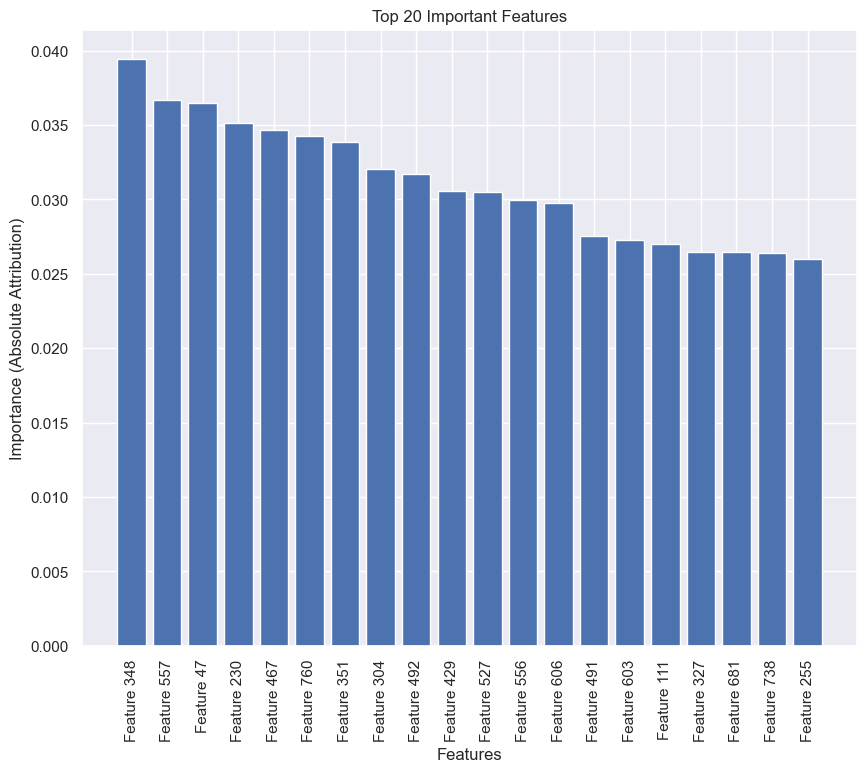

In [33]:
# Convert the attributions to a numpy array and take the absolute to consider overall impact
attributions_array = attributions.detach().numpy()  # assuming your data is on CPU, remove .detach() otherwise

# Generate a bar chart
feature_names = [f"Feature {i}" for i in range(len(attributions_array))]  # Replace with real feature names if available
importance_scores = np.abs(attributions_array)

# Sort features by importance
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_features = [feature_names[idx] for idx in sorted_indices]
sorted_importance = importance_scores[sorted_indices]

plt.figure(figsize=(10, 8))
plt.bar(sorted_features[:20], sorted_importance[:20], color='b')  # Adjust the slice for more or fewer features
plt.xticks(rotation=90)
plt.title('Top 20 Important Features')
plt.xlabel('Features')
plt.ylabel('Importance (Absolute Attribution)')
plt.show()


In [34]:
# We need to map each sequence of tokens back to their corresponding ICD codes
# Let's extract token to ICD code mapping from the tokenized sequences
icd_code_to_tokens = {}
for index, row in train_icd_sequences.iterrows():
    # tokenize the icd_sequence to get token ids, similar to what was done before but now we keep the mapping
    tokens = tokenizer.encode(row['icd_sequence'], add_special_tokens=False)
    icd_codes = row['icd_sequence'].split()
    for code, token in zip(icd_codes, tokens):
        if code not in icd_code_to_tokens:
            icd_code_to_tokens[code] = []
        icd_code_to_tokens[code].append(token)


In [35]:
def compute_attributions(model, embeddings):
    # IntegratedGradients requires the model and the input tensors to be on the same device.
    # Ensure `embeddings` is on the same device as your model's parameters.
    embeddings = embeddings.to(model.fc1.weight.device)
    integrated_gradients = IntegratedGradients(model)
    
    # Create a baseline which is a tensor of zeros with the same shape as the embeddings
    baselines = torch.zeros_like(embeddings)

    # Compute attributions using Integrated Gradients
    # `target=0` is appropriate here assuming you're interested in the output of the sigmoid for class '1'
    attributions = integrated_gradients.attribute(inputs=embeddings,
                                                  baselines=baselines,
                                                  target=0)

    # Since there's no sequence dimension, the sum across feature dimension directly aggregates per-input attributions
    return attributions.sum(dim=-1)

In [36]:
# Compute attributions using the embeddings
attributions = compute_attributions(model, train_embeddings)

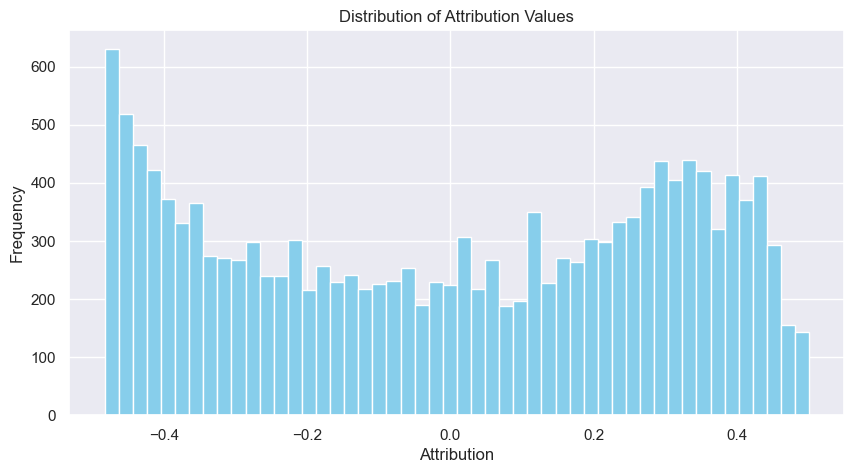

In [37]:
plt.figure(figsize=(10, 5))
plt.hist(attributions.numpy(), bins=50, color='skyblue')
plt.title('Distribution of Attribution Values')
plt.xlabel('Attribution')
plt.ylabel('Frequency')
plt.show()

In [38]:
# Convert attributions to a numpy array for easier handling
attributions_np = attributions.numpy()

# Get indices of the top positive and negative attributions
top_positive_indices = attributions_np.argsort()[-10:][::-1]  # Top 10 positive
top_negative_indices = attributions_np.argsort()[:10]          # Top 10 negative

print("Top Positive Attribution Indices and Values:")
for idx in top_positive_indices:
    print(f"Index: {idx}, Attribution: {attributions_np[idx]}")

print("\nTop Negative Attribution Indices and Values:")
for idx in top_negative_indices:
    print(f"Index: {idx}, Attribution: {attributions_np[idx]}")


Top Positive Attribution Indices and Values:
Index: 9273, Attribution: 0.5012860058742004
Index: 13397, Attribution: 0.5012860058742004
Index: 12642, Attribution: 0.5012860058742004
Index: 12077, Attribution: 0.5012860058742004
Index: 12512, Attribution: 0.5012860058742004
Index: 13580, Attribution: 0.5012860058742004
Index: 13206, Attribution: 0.5012860058742004
Index: 12821, Attribution: 0.5012860058742004
Index: 9231, Attribution: 0.5012860058742004
Index: 11836, Attribution: 0.5012860058742004

Top Negative Attribution Indices and Values:
Index: 2246, Attribution: -0.48330512582001384
Index: 6023, Attribution: -0.4831222591526365
Index: 593, Attribution: -0.48305564581986615
Index: 4262, Attribution: -0.48298249924644876
Index: 6972, Attribution: -0.48295829238867416
Index: 383, Attribution: -0.4829418169782732
Index: 3923, Attribution: -0.48293603044706934
Index: 5110, Attribution: -0.4829295926754538
Index: 5935, Attribution: -0.4828246879491994
Index: 7243, Attribution: -0.48279

In [39]:
# Prepare a dictionary to hold the aggregated attributions for each ICD code
icd_code_attributions = {}

# Iterate over each ICD code and its list of tokens
for icd_code, tokens in icd_code_to_tokens.items():
    # Filter out the attributions for tokens associated with the current ICD code
    # Note: This assumes `attributions` is a PyTorch tensor or numpy array where the position corresponds to the token index
    token_attributions = [attributions[token_id] for token_id in set(tokens) if token_id < len(attributions)]
    if token_attributions:
        # Calculate the mean attribution for the current ICD code
        icd_code_attributions[icd_code] = np.mean(token_attributions)

# Optionally, sort the ICD codes by their average attributions
sorted_icd_code_attributions = sorted(icd_code_attributions.items(), key=lambda x: x[1], reverse=True)

# Save the attributions to a csv file
sorted_icd_code_attributions_df = pd.DataFrame(sorted_icd_code_attributions, columns=["ICD-Code", "Attribution"])
sorted_icd_code_attributions_df.to_csv(f"./saved_models/Med-BERT/trained_on_{percentage}/icd_code_attributions.csv")

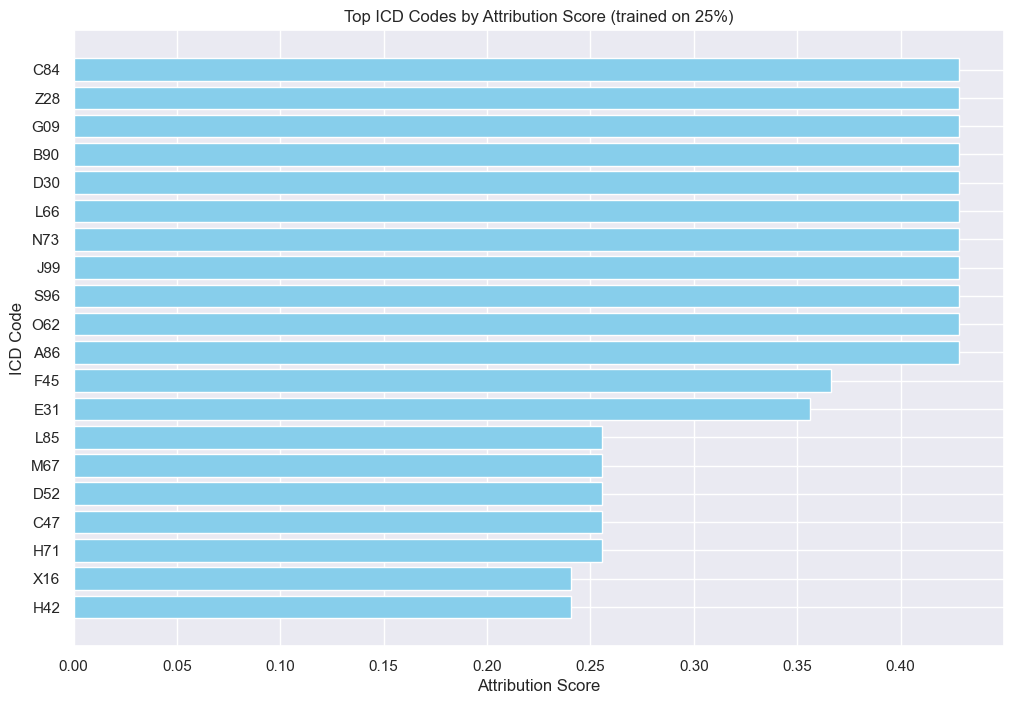

In [40]:
# Assuming 'sorted_icd_code_attributions' is your sorted list of ICD codes and their attributions
# For example, it might look like this if you sorted it in your previous code:
# sorted_icd_code_attributions = sorted(icd_code_attributions.items(), key=lambda x: x[1], reverse=True)

# Prepare the data for plotting
icd_codes, attributions = zip(*sorted_icd_code_attributions)  # Unzip the list of tuples into two tuples

# Let's plot the top 20 ICD codes for clarity
top_n = 20
icd_codes_top = icd_codes[:top_n]
attributions_top = attributions[:top_n]

# Creating the bar plot
plt.figure(figsize=(12, 8))
plt.barh(icd_codes_top, attributions_top, color='skyblue')
plt.xlabel('Attribution Score')
plt.ylabel('ICD Code')
plt.title(f'Top ICD Codes by Attribution Score (trained on {percentage})')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values on top
plt.savefig(f"./saved_models/Med-BERT/trained_on_{percentage}/top_icd_attributions", bbox_inches='tight')
plt.show()

In [41]:
def icd_to_category(icd_code):
    if icd_code.startswith('A') or icd_code.startswith('B'):
        return 'Infectious and Parasitic Diseases'
    elif icd_code.startswith('C') or (icd_code.startswith('D') and int(icd_code[1:]) < 50):
        return 'Neoplasms'
    elif (icd_code.startswith('D') and int(icd_code[1:]) >= 50):
        return 'Diseases of the Blood and Blood-Forming Organs and Certain Disorders Involving the Immune Mechanism'
    elif icd_code.startswith('E'):
        return 'Endocrine, Nutritional and Metabolic Diseases'
    elif icd_code.startswith('F'):
        return 'Mental and Behavioral Disorders'
    elif icd_code.startswith('G'):
        return 'Diseases of the Nervous System'
    elif icd_code.startswith('H') and int(icd_code[1:]) < 60:
        return 'Diseases of the Eye and Adnexa'
    elif icd_code.startswith('H') and int(icd_code[1:]) >= 60:
        return 'Diseases of the Ear and Mastoid Process'
    elif icd_code.startswith('I'):
        return 'Circulatory System Diseases'
    elif icd_code.startswith('J'):
        return 'Diseases of the Respiratory System'
    elif icd_code.startswith('K'):
        return 'Diseases of the Digestive System'
    elif icd_code.startswith('L'):
        return 'Diseases of the Skin and Subcutaneous Tissue'
    elif icd_code.startswith('M'):
        return 'Diseases of the Musculoskeletal System and Connective Tissue'
    elif icd_code.startswith('N'):
        return 'Diseases of the Genitourinary System'
    elif icd_code.startswith('O'):
        return 'Pregnancy, Childbirth and the Puerperium'
    elif icd_code.startswith('P'):
        return 'Certain Conditions Originating in the Perinatal Period'
    elif icd_code.startswith('Q'):
        return 'Congenital Malformations, Deformations and Chromosomal Abnormalities'
    elif icd_code.startswith('R'):
        return 'Symptoms, Signs and Abnormal Clinical and Laboratory Findings, Not Elsewhere Classified'
    elif icd_code.startswith('S') or icd_code.startswith('T'):
        return 'Injury, Poisoning and Certain Other Consequences of External Causes'
    elif icd_code.startswith('V') or icd_code.startswith('W') or icd_code.startswith('X') or icd_code.startswith('Y'):
        return 'External Causes of Morbidity'
    elif icd_code.startswith('Z'):
        return 'Factors Influencing Health Status and Contact with Health Services'
    else:
        return 'Other'


# Apply the Mapping
icd_categories = {code: icd_to_category(code) for code in icd_code_to_tokens.keys()}


ValueError: invalid literal for int() with base 10: '3A'

In [42]:
# Initialize a dictionary to hold summed attributions by category
category_attributions = defaultdict(float)
category_counts = defaultdict(int)

for icd_code, attribution in icd_code_attributions.items():
    category = icd_to_category(icd_code)
    category_attributions[category] += attribution
    category_counts[category] += 1

# Calculate the average attribution per category
category_average_attributions = {cat: category_attributions[cat] / category_counts[cat] for cat in category_attributions}

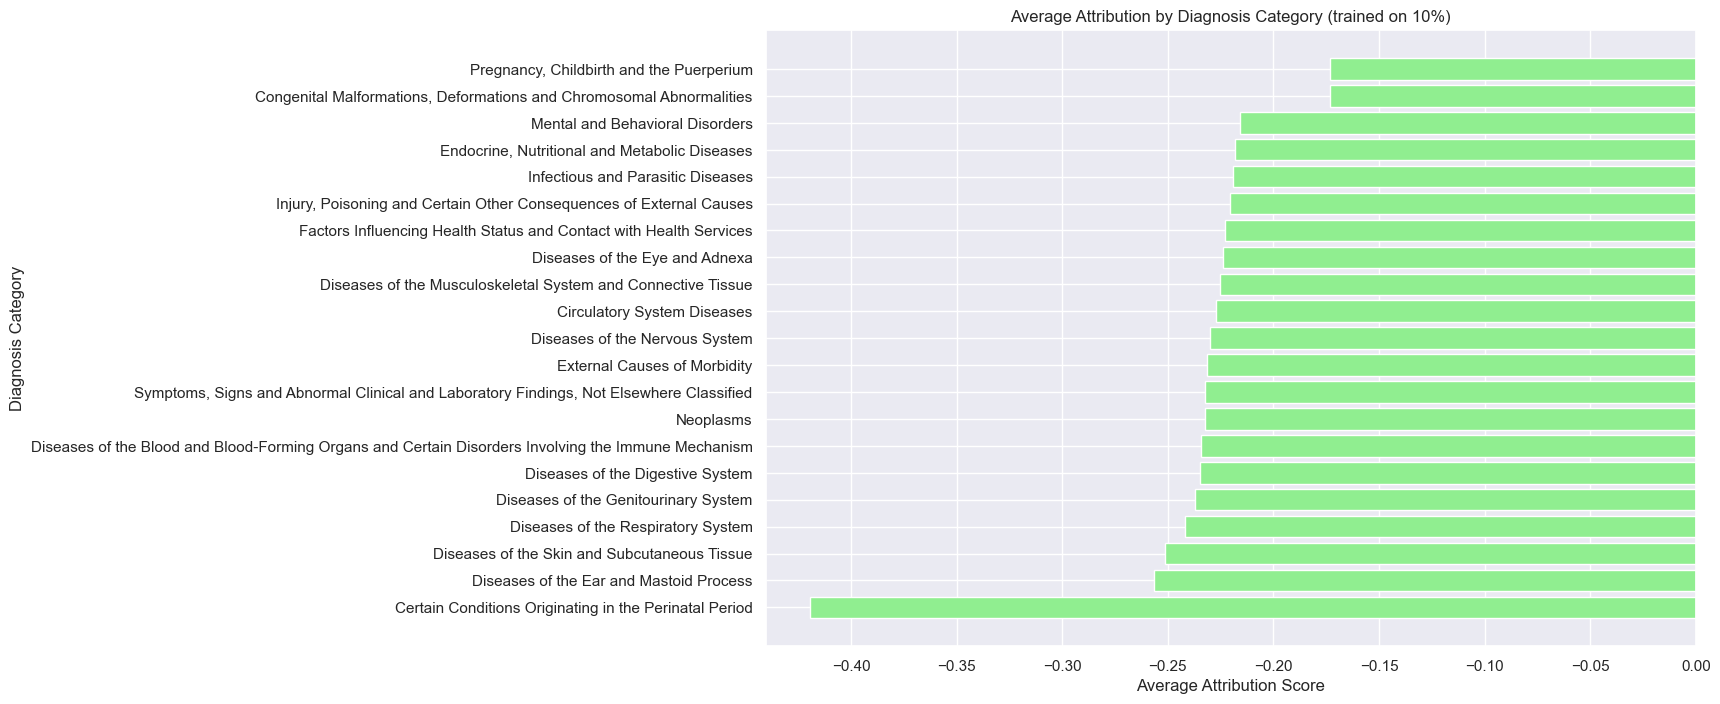

In [43]:
categories, avg_attributions = zip(*sorted(category_average_attributions.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 8))
plt.barh(categories, avg_attributions, color='lightgreen')
plt.xlabel('Average Attribution Score')
plt.ylabel('Diagnosis Category')
plt.title(f'Average Attribution by Diagnosis Category (trained on {percentage})')
plt.gca().invert_yaxis()
plt.savefig(f"./saved_models/Med-BERT/trained_on_{percentage}/top_category_attributions", bbox_inches='tight')
plt.show()